In [2]:
import pandas as pd
from pathlib import Path
import logging
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

from portraits.utils import read_gene_sets, ssgsea_formula, median_scale
from portraits.clustering import clustering_profile_metrics, clustering_profile_metrics_plot,clustering_select_best_tr

def get_notebook_logger(name=__name__):
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    
    # Avoid duplicate handlers if the cell is run multiple times
    if not logger.handlers:
        # StreamHandler(sys.stdout) ensures it prints to the cell
        handler = logging.StreamHandler(sys.stdout)
        handler.setLevel(logging.INFO)
        
        formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        
        logger.addHandler(handler)
    
    # Prevent logs from double-printing if the root logger is also active
    logger.propagate = False
    return logger

logger = get_notebook_logger("Clustering")
logger.info("Logger is ready!")

Clustering - INFO - Logger is ready!


In [3]:
def read_expression_matrix(path: Path) -> pd.DataFrame:
    logger.info(f"Reading expression matrix from:\n\t{path}")
    df = pd.read_csv(path, sep='\t', index_col=0).T
    logger.info("Shape of expression matrix is {}".format(df.shape))
    return pd.read_csv(path, sep='\t', index_col=0).T

cohorts_dir = Path("../Cohorts").resolve()
assert cohorts_dir.exists() and cohorts_dir.is_dir()
TCGA_expression = read_expression_matrix(
    cohorts_dir.joinpath("TCGA_input_expressions/expressions.tsv.gz")
)

TCGA_expression.head()

Clustering - INFO - Reading expression matrix from:
	/Users/halu/Code/MFP/Cohorts/TCGA_input_expressions/expressions.tsv.gz
Clustering - INFO - Shape of expression matrix is (412, 20062)


Gene,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
TCGA-GC-A6I3-11,0.000000,0.043268,8.481033,1.010844,0.123756,5.330241,0.000000,4.409425,2.157397,3.617803,...,3.741586,0.606180,1.472148,1.546339,0.387015,1.470805,7.065590,2.056408,0.202349,2.286623
TCGA-XF-A9SU-01,0.000000,0.010951,7.640422,1.710115,0.000000,4.933957,0.000000,5.116923,2.780621,2.746503,...,4.173330,0.542029,1.763678,2.082953,0.330899,2.447285,7.880771,1.927284,0.549840,3.022682
TCGA-DK-AA6R-01,0.000000,0.042670,5.482871,6.416485,0.053872,5.753585,0.084866,4.679069,5.414179,0.786724,...,5.577450,1.216666,2.286529,3.422629,1.328547,2.978730,7.675493,2.468195,3.155729,4.445754
TCGA-E7-A677-01,0.129864,0.292750,6.631318,0.847016,0.177503,6.634323,0.076166,5.332937,4.352037,0.683870,...,5.023908,1.513659,2.449552,3.342000,0.339079,3.058979,7.410880,2.556345,3.900757,3.066961
TCGA-FD-A6TG-01,0.000000,0.064640,9.314429,5.065935,0.000000,5.030549,0.024996,5.195107,3.936387,5.340507,...,5.553707,1.371802,2.574744,3.589222,0.346186,3.710227,7.729143,2.986841,3.106927,4.770428


In [4]:
signatures_dir = Path("../signatures").resolve()
assert signatures_dir.exists() and signatures_dir.is_dir()
gmt = read_gene_sets(signatures_dir.joinpath('gene_signatures.gmt'))
logger.info(f"Read {len(gmt)} gene sets from:\n\t{signatures_dir.joinpath('gene_signatures.gmt')}")

Clustering - INFO - Read 29 gene sets from:
	/Users/halu/Code/MFP/signatures/gene_signatures.gmt


In [5]:
TCGA_expression.head()

Gene,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
TCGA-GC-A6I3-11,0.000000,0.043268,8.481033,1.010844,0.123756,5.330241,0.000000,4.409425,2.157397,3.617803,...,3.741586,0.606180,1.472148,1.546339,0.387015,1.470805,7.065590,2.056408,0.202349,2.286623
TCGA-XF-A9SU-01,0.000000,0.010951,7.640422,1.710115,0.000000,4.933957,0.000000,5.116923,2.780621,2.746503,...,4.173330,0.542029,1.763678,2.082953,0.330899,2.447285,7.880771,1.927284,0.549840,3.022682
TCGA-DK-AA6R-01,0.000000,0.042670,5.482871,6.416485,0.053872,5.753585,0.084866,4.679069,5.414179,0.786724,...,5.577450,1.216666,2.286529,3.422629,1.328547,2.978730,7.675493,2.468195,3.155729,4.445754
TCGA-E7-A677-01,0.129864,0.292750,6.631318,0.847016,0.177503,6.634323,0.076166,5.332937,4.352037,0.683870,...,5.023908,1.513659,2.449552,3.342000,0.339079,3.058979,7.410880,2.556345,3.900757,3.066961
TCGA-FD-A6TG-01,0.000000,0.064640,9.314429,5.065935,0.000000,5.030549,0.024996,5.195107,3.936387,5.340507,...,5.553707,1.371802,2.574744,3.589222,0.346186,3.710227,7.729143,2.986841,3.106927,4.770428


In [15]:
signature_scores = ssgsea_formula(np.log2(TCGA_expression), gmt)
signature_scores_scaled = median_scale(signature_scores)
signature_scores_scaled.head()

/Users/halu/miniconda3/envs/MFP/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/Users/halu/Code/MFP/portraits/utils.py:63: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  c_data = (data - data.median()) / data.mad()


,MHCI,MHCII,Coactivation_molecules,Effector_cells,T_cell_traffic,NK_cells,T_cells,B_cells,M1_signatures,Th1_signature,...,Macrophage_DC_traffic,Th2_signature,Protumor_cytokines,CAF,Matrix,Matrix_remodeling,Angiogenesis,Endothelium,Proliferation_rate,EMT_signature
TCGA-GC-A6I3-11,0.083432,0.987001,3.880472,2.214178,0.515701,1.904412,2.628548,5.926074,1.286390,1.917477,...,0.634968,3.018433,1.924009,0.345046,-0.438335,0.428441,1.561478,2.147181,-0.289973,1.923373
TCGA-XF-A9SU-01,-1.638832,0.048784,0.501064,0.485459,0.470731,0.058196,0.797727,1.439240,0.539672,-0.031413,...,0.461279,-0.951095,1.158496,0.771374,0.707412,1.041234,0.072101,0.383419,0.230943,1.216322
TCGA-DK-AA6R-01,1.427933,-1.303327,-0.594217,0.735304,1.246757,1.079800,-0.200940,-0.564154,0.384611,1.748115,...,0.211941,-0.113098,0.719381,0.093255,1.392075,1.296230,0.800060,-0.533786,1.246761,0.358953
TCGA-E7-A677-01,0.138957,-0.185318,0.575455,-0.422677,0.456692,-0.702405,0.237396,-0.522376,1.219193,0.209528,...,-0.181841,-0.252897,-0.576956,-0.851821,0.234857,1.030135,1.385839,-0.400100,-1.308200,-1.105099
TCGA-FD-A6TG-01,-1.021296,0.560027,0.060357,0.000614,0.422613,-0.230438,0.404963,1.434768,-1.544670,-0.479280,...,-0.111018,-0.819020,-0.295109,1.116390,0.535043,-0.709582,-0.452178,1.313575,-0.432566,0.060087


In [16]:
clustering_metrics = clustering_profile_metrics(signature_scores_scaled, threshold_mm=(.3, .65), step=.01)

100%|██████████| 35/35 [00:11<00:00,  2.99it/s]


<Axes: ylabel='Cluster %'>

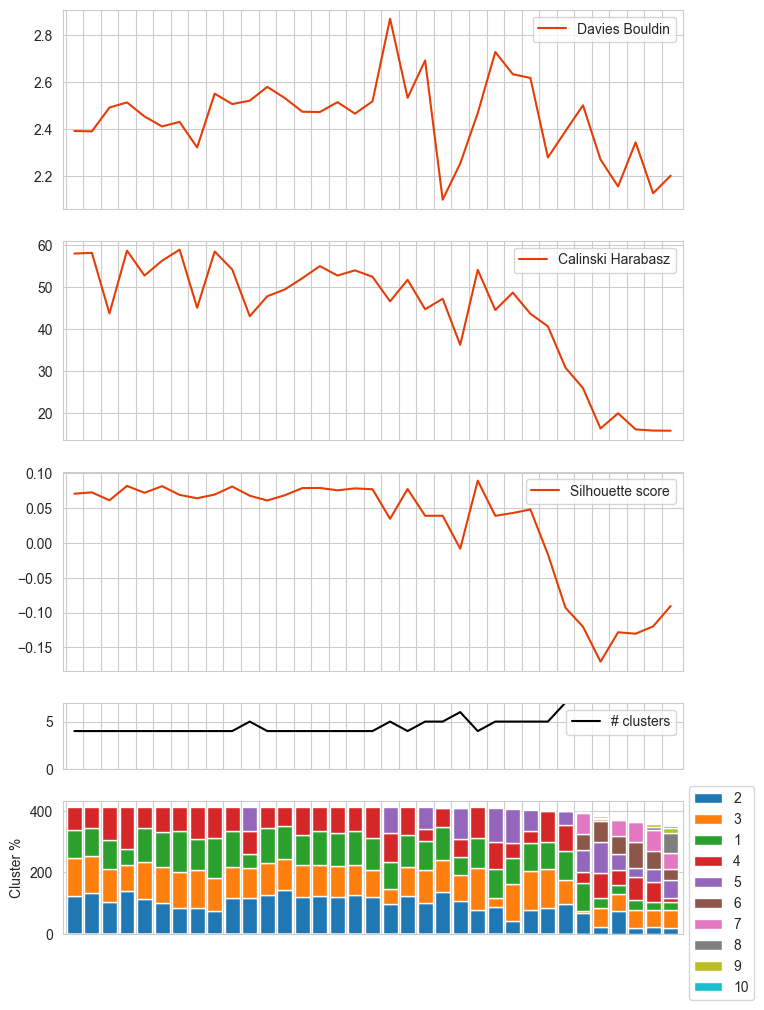

In [17]:
clustering_profile_metrics_plot(clustering_metrics)

In [18]:
best_threshold = 0.37
classified_samples = clustering_metrics["perc"][str(best_threshold)]
classified_samples

TCGA-GC-A6I3-11    1
TCGA-CF-A47Y-01    1
TCGA-G2-AA3D-01    2
TCGA-UY-A8OD-01    1
TCGA-S5-A6DX-01    2
                  ..
TCGA-C4-A0EZ-01    3
TCGA-S5-AA26-01    3
TCGA-GV-A3QI-01    3
TCGA-ZF-AA54-01    4
TCGA-CU-A0YR-01    3
Name: MFP, Length: 412, dtype: int64

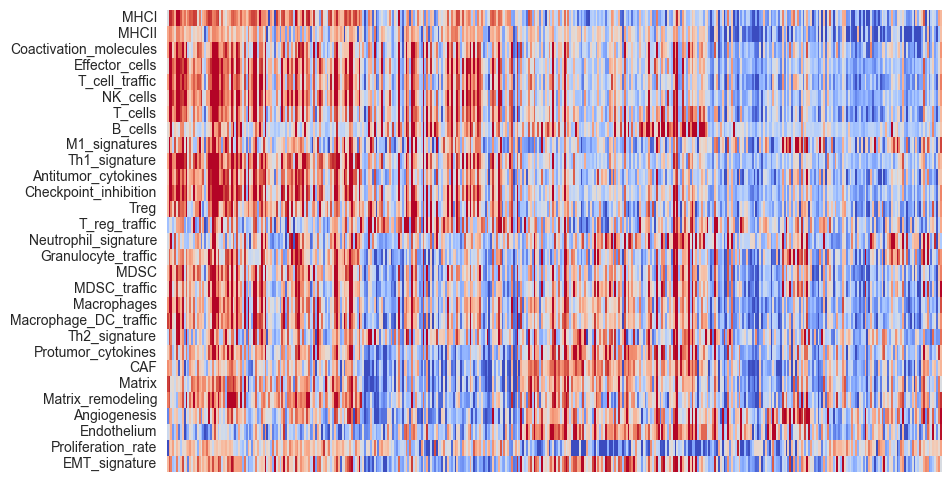

In [19]:
order = ["IE+F", "IE", "F", "D"]
ordered_classified_samples = pd.Series(
    pd.Categorical(
        classified_samples.map({1: "F",2: "IE",3: "D",4: "IE+F"}),
        categories=order,
        ordered=True
    ),
    index=classified_samples.index,
    name="subtype"
).sort_values()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(
    signature_scores_scaled.loc[ordered_classified_samples.sort_values().index].clip(-2, 2).T,
    yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm,ax=ax
)
plt.savefig
plt.show()

In [20]:
df = signature_scores_scaled.loc[ordered_classified_samples.sort_values().index].clip(-2, 2)
df = df.groupby(ordered_classified_samples).mean().T
df

subtype,IE+F,IE,F,D
MHCI,1.047789,0.172616,-0.381128,-0.684610
MHCII,0.300156,0.072613,0.052255,-1.122344
Coactivation_molecules,0.728753,0.291832,0.133670,-0.614335
Effector_cells,1.075365,0.480137,0.085698,-0.691614
T_cell_traffic,1.006967,0.214724,-0.011238,-0.778082
NK_cells,1.140033,0.526884,0.012280,-0.630852
T_cells,0.703109,0.485013,0.294347,-0.747939
B_cells,0.223459,0.638194,0.729292,-0.326336
M1_signatures,0.413369,-0.011990,-0.373679,-0.048676
Th1_signature,1.219233,0.487262,-0.097857,-0.514878


In [21]:
df

subtype,IE+F,IE,F,D
MHCI,1.047789,0.172616,-0.381128,-0.684610
MHCII,0.300156,0.072613,0.052255,-1.122344
Coactivation_molecules,0.728753,0.291832,0.133670,-0.614335
Effector_cells,1.075365,0.480137,0.085698,-0.691614
T_cell_traffic,1.006967,0.214724,-0.011238,-0.778082
NK_cells,1.140033,0.526884,0.012280,-0.630852
T_cells,0.703109,0.485013,0.294347,-0.747939
B_cells,0.223459,0.638194,0.729292,-0.326336
M1_signatures,0.413369,-0.011990,-0.373679,-0.048676
Th1_signature,1.219233,0.487262,-0.097857,-0.514878


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(scaled_data)
pathway_cluster = pd.DataFrame(data=[df.index, clusters]).T
pathway_cluster.columns = ["pathway_name", "pathway_cluster"]
pathway_cluster = pathway_cluster.sort_values(["pathway_cluster", "pathway_name"]).reset_index(drop=True)
pathway_cluster

,pathway_name,pathway_cluster
0,Antitumor_cytokines,0
1,B_cells,0
2,Checkpoint_inhibition,0
3,Coactivation_molecules,0
4,Effector_cells,0
5,MDSC,0
6,MHCI,0
7,MHCII,0
8,Macrophage_DC_traffic,0
9,Macrophages,0


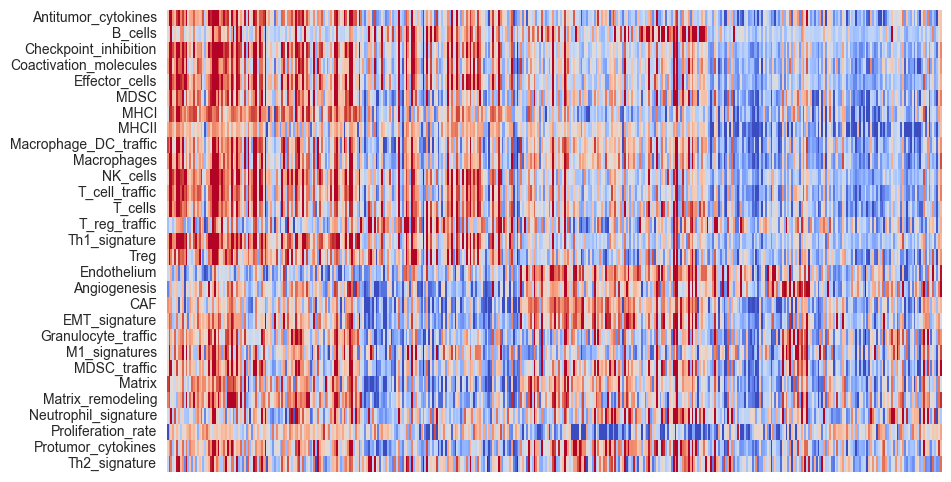

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(
    signature_scores_scaled.loc[ordered_classified_samples.sort_values().index, pathway_cluster["pathway_name"]].clip(-2, 2).T,
    yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm,ax=ax
)
plt.show()